In [138]:
from pypion.ReadData import ReadData
from pypion.argparse_command import InputValues
import yt

import numpy as np
import math
from astropy import units as u

import os
import glob
import re

yt.set_log_level(30)

# %matplotlib notebook

In [3]:

class Plot_Functions:
    def __init__(self, path, image_dir, fluid_quantity, tolerance, plane):
        ########### Defining path to SILO files #######################
        self.data_path = path
        if os.path.exists(path):
            print(f"Chosen datapath: {path}")
        else:
            print(f"Directory does not exist: {path}")
            exit()
            
        ########### Base name of SILO files ############################
        self.filename=sorted(os.listdir(self.data_path))[2].replace('_level00_0000.00000000.silo','')
        print(self.filename)

        ########### Define desired fluid quantity ######################
        self.Quantity = fluid_quantity
        print(f"Fluid quantity: {self.Quantity}")
        self.Tolerance = tolerance
        print(f"vmin: {self.Tolerance[0]} \nvmax: {self.Tolerance[1]}")

        ########### If 3D, specify the coordinate plane ################
        surface_options = ['XY', 'XZ', 'YZ']
        self.Surface = plane
        if surface_options.count(self.Surface) > 0:
            print(f"Chosen surface: {self.Surface}")
        else:
            print(f"Invalid Surface Choice: {self.Surface}")
            exit()

        ########### Make snapshots of the simulation ###################
        self.evolution = self.make_snapshots(self.data_path, self.filename)

        ########### Find the dimensions of the simulation ##############
        self.find_dimensions()

    @staticmethod
    def make_snapshots(data_path, filename):
        ########## Cataloging silo files ###############################
        os.chdir(data_path)
        file_list = glob.glob('*.silo', recursive=True)
        level_list = []
        files = []

        for file in file_list:
            level = re.search('_level(.*)_', file)
            if level == None:
                pass
            else:
                level = level.group(1)
                if not level in level_list:
                    level_list.append(level)
        level_list.sort()

        ########## Categorizing data files into levels #################
        if len(level_list) == 1: 
            print('Simulation Info: Single level')
            catalog = []
            files = sorted(glob.glob(filename + '_0000.*.silo'))
            catalog.append(files)
        else:
            print(f'Simulation Info: {len(level_list)} levels')
            catalog = []
            for i in range(len(level_list)):
                files = sorted(glob.glob(f"{filename}_level{level_list[i]}_0000.*.silo"))
                catalog.append(files)
                
        # Bundle silo files of different levels of same time instant into a snapshot.
        evolution = np.array(catalog).T
        print(f"Shape of evolution array: {evolution.shape}")
        return evolution

    def find_dimensions(self):
        # Looking inside the simulation file for dimensions.
        info = ReadData(self.evolution[0])
        self.N_grids = info.ngrid()
        self.N_levels = info.nlevels()

        self.N_dims = 0
        for j in range(len(self.N_grids)):
            if self.N_grids[j] > 1: self.N_dims += 1
        print(f'Simulation Info: {self.N_dims}D System')
        #End of making snapshots ***************************************************


In [4]:
wr140 = Plot_Functions(path="/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/orig_res/wr140-hydro-cool-n064/",
                    image_dir="/mnt/local/thomas/yt_images/",
                    fluid_quantity="density",
                    tolerance=[1e-30, 1e-20],
                    plane="XY")

Chosen datapath: /mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/orig_res/wr140-hydro-cool-n064/
WR140_hydro_cool_d3l6n064
Fluid quantity: density
vmin: 1e-30 
vmax: 1e-20
Chosen surface: XY
Simulation Info: 6 levels
Shape of evolution array: (423, 6)
Simulation Info: 3D System


In [140]:
def get_ds(file) -> dict:
    data = ReadData(file)
    sim_time = data.sim_time()
    N_levels = data.nlevels()
    N_grids = data.ngrid()
    Dom_size = str(max(data.level_max()) - max(data.level_min()))

    data_den = data.get_3Darray("Density")['data']
    data_temp = data.get_3Darray("Temperature")['data']
    data_velx = data.get_3Darray("VelocityX")['data']
    data_vely = data.get_3Darray("VelocityY")['data']
    data_velz = data.get_3Darray("VelocityZ")['data']
    # data_ngmask = data.get_3Darray("NG_Mask")['data']

    grid_data = [dict(left_edge=[0.5-0.5**(n+1)]*len(N_grids), right_edge=[0.5+0.5**(n+1)]*len(N_grids), level=n, dimensions=N_grids) for n in range(N_levels)]

    i = 0
    for g in grid_data:
        g[("gas", "density")] = (data_den[i], "g/cm**3")
        g[("gas", "temperature")] = (data_temp[i], "K")
        g[("gas", "velocity_x")] = (data_velx[i], "cm/s")
        g[("gas", "velocity_y")] = (data_vely[i], "cm/s")
        g[("gas", "velocity_z")] = (data_velz[i], "cm/s")
        # g[("gas", "NG_Mask")] = (data_ngmask[i], "cm/s")
        i += 1

    ds = yt.load_amr_grids(grid_data, N_grids, length_unit=f"{Dom_size} * cm", geometry=("cartesian", ("z","y","x")), sim_time=sim_time)
    return {"ds": ds, "sim_time": sim_time}

def get_ts(files):
    ds_list = []
    sim_time_list = []
    for file in files:
        ds = get_ds(file)
        ds_list.append(ds["ds"])
        sim_time_list.append(ds["sim_time"])
        ds.clear()
    
    ts = yt.DatasetSeries(ds_list)
    return ts

    


In [158]:
files = wr140.evolution[100:110]

ts = get_ts(files)

In [159]:
def get_time_series():

    ds_list = []

    for i in range(100,121):
        data = ReadData(wr140.evolution[i])
        sim_time = data.sim_time()
        N_levels = data.nlevels()
        N_grids = data.ngrid()

        arr = np.array(wr140.evolution[i])

        data_den = ReadData(arr).get_3Darray("Density")['data']
        data_temp = ReadData(arr).get_3Darray("Temperature")['data']
        data_velx = ReadData(arr).get_3Darray("VelocityX")['data']
        data_vely = ReadData(arr).get_3Darray("VelocityY")['data']
        data_velz = ReadData(arr).get_3Darray("VelocityZ")['data']
        # data_ngmask = ReadData(arr).get_3Darray("NG_Mask")['data']

        grid_data = [dict(left_edge=[0.5-0.5**(n+1)]*len(N_grids), right_edge=[0.5+0.5**(n+1)]*len(N_grids), level=n, dimensions=N_grids) for n in range(N_levels)]

        i = 0
        for g in grid_data:
            g[("gas", "density")] = (data_den[i], "g/cm**3")
            g[("gas", "temperature")] = (data_temp[i], "K")
            g[("gas", "velocity_x")] = (data_velx[i], "cm/s")
            g[("gas", "velocity_y")] = (data_vely[i], "cm/s")
            g[("gas", "velocity_z")] = (data_velz[i], "cm/s")
            # g[("gas", "NG_Mask")] = (data_ngmask[i], "cm/s")
            i += 1


        ds = yt.load_amr_grids(grid_data, N_grids, length_unit="1e15 * cm", geometry=("cartesian", ("z","y","x")),sim_time=sim_time)
        ds_list.append(ds)  
        ds.close()
        data.close()
        grid_data.clear()
        

    ts = yt.DatasetSeries(ds_list)

    return ts

In [248]:
def plot_slice(ds, normal, plot_field, **kwargs):
    slc = yt.SlicePlot(ds, normal, fields=plot_field, center=kwargs.get('center', 'c'))
    slc.set_cmap(plot_field, kwargs.get('cmap', 'viridis'))
    slc.annotate_timestamp(corner='upper_left', time_format='t = {time:.2f} {units}', time_unit='yr', redshift=False, draw_inset_box=True)
    
    slc.zoom(kwargs.get('zoom', 1))
    slc.annotate_grids(kwargs.get('annotate_grids', False))
    
    def annotate_velocity(plot, annotate_velocity=False):
        if annotate_velocity == True:
            plot.annotate_velocity()
    
    def annotate_streamlines(plot, annotate_streamlines=False):
        if annotate_streamlines == True:
            plot.annotate_streamlines('velocity_x', 'velocity_y')

    annotate_velocity(slc, kwargs.get('annotate_velocity', False))
    annotate_streamlines(slc, kwargs.get('annotate_streamlines', False))
    
    return slc

In [271]:
def t_inst_render(ds, field, **kwargs):
    sc = yt.create_scene(ds)
    source = sc[0]
    source.set_field(field)
    source.set_log(kwargs.get('log', True))

    bounds = kwargs.get('bounds', (1e-18, 1e-12))
    tf = yt.ColorTransferFunction(x_bounds = np.log10(bounds))
    tf.add_layers(3, w=0.003, colormap=kwargs.get('cmap', 'viridis'))

    source.tfh.tf = tf
    source.tfh.bounds = bounds
    # source.tfh.plot(kwargs.get(f'{image_dir}/{}'), profile_field=field)

    cam = sc.camera
    cam.zoom(kwargs.get('zoom', 1))

    return cam

In [ ]:



for j in cam.iter_zoom(1+(i*4/20), 5):
    sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/{i}frame_{j+1}.png', sigma_clip=6.0, render=True)

In [270]:
for i in range(len(ts)):
    sc = yt.create_scene(ts[i])
    # identifying the source
    source = sc[0]
    source.set_field('density')
    source.set_log(True)

    # building transfer function
    bounds = (1e-18, 1e-12)
    tf = yt.ColorTransferFunction(x_bounds=np.log10(bounds))
    tf.add_layers(5, w=0.005, colormap='viridis')
    
    source.tfh.tf = tf
    source.tfh.bounds = bounds
    # source.tfh.plot(f'/home/visitor_ap4/code/project/scripts/wr140_tf{i}_density.png', profile_field='density')
    
    cam = sc.camera
    cam.zoom(4)
    # cam.switch_orientation(normal_vector=[1, 0, 0], north_vector=[0, 1, 0])

    sc.save(f'/home/visitor_ap4/code/project/scripts/frame_{i}.png', sigma_clip=6.0)
    
    tf.clear()

yt : [WARNING  ] 2022-10-28 15:57:43,325 No previously rendered image found, rendering now.


In [262]:
for ds in ts:
    sc = t_inst_render(ds, "density", zoom=1)
    sc.save(os.path.join(os.cwd(), f"density_render{ds.sim_time}.png"))


In [ ]:
slc = plot_slice(ts[9], "z","density", zoom=2, show_grids=True)
slc.show()


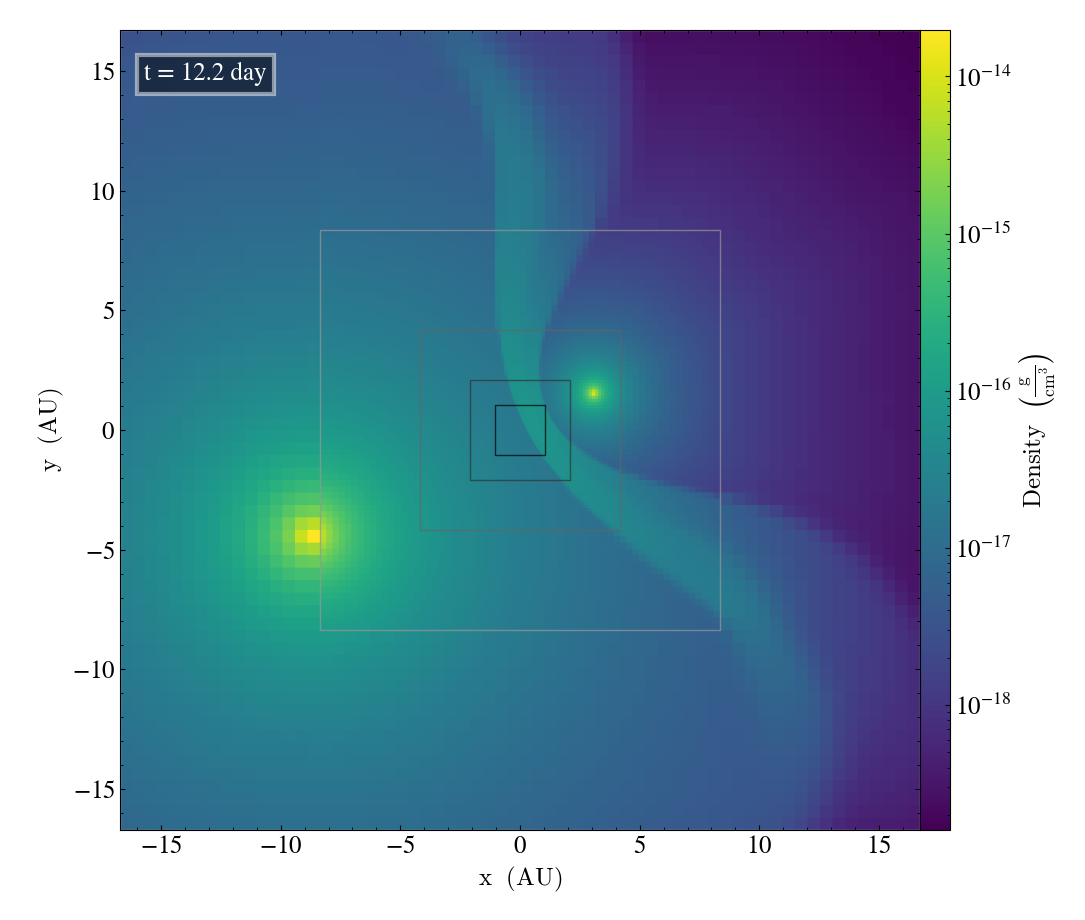

In [144]:
slc = yt.SlicePlot(ts[9], "z", "density", center=('c'),).annotate_grids()
yt.SlicePlot()
slc.set_cmap("density", "viridis")

slc.zoom(2)
# slc.set_width((1.0, 'cm'))
# slc.annotate_velocity(normalize=True)
# slc.annotate_streamlines("velocity_x", "velocity_y", factor=10, density=2, color="white")
# slc.annotate_contour("temperature", levels=10, clim=(1e6, 1e8), plot_args={"colors":"white"})
# slc.annotate_cell_edges(line_width=0.0005, alpha=0.5)

slc.annotate_timestamp(corner="upper_left", redshift=False, draw_inset_box=True)
# slc.annotate_line_integral_convolution(("gas", "velocity_x"), ("gas", "velocity_y"), lim=(0.5, 0.75))
slc.show()

yt : [INFO     ] 2022-10-27 19:31:50,887 Setting default field to ('gas', 'density')


<Color Transfer Function Object>:
x_bounds:[-18, -12] nbins:256 features:
	('gaussian', 'location(x):-18', 'width(x):0.005', 'height(y):(0.27, 0.031, 0.36, 0.001)')
	('gaussian', 'location(x):-16', 'width(x):0.005', 'height(y):(0.23, 0.33, 0.55, 0.0056)')
	('gaussian', 'location(x):-15', 'width(x):0.005', 'height(y):(0.13, 0.57, 0.55, 0.032)')
	('gaussian', 'location(x):-14', 'width(x):0.005', 'height(y):(0.34, 0.78, 0.4, 0.18)')
	('gaussian', 'location(x):-12', 'width(x):0.005', 'height(y):(0.95, 0.9, 0.11,   1)')



yt : [WARNING  ] 2022-10-27 19:31:51,645 No previously rendered image found, rendering now.
yt : [INFO     ] 2022-10-27 19:31:51,647 Rendering scene (Can take a while).
yt : [INFO     ] 2022-10-27 19:31:51,649 Creating volume
yt : [INFO     ] 2022-10-27 19:31:52,945 Saving rendered image to /home/visitor_ap4/code/project/scripts/wr140_density.png


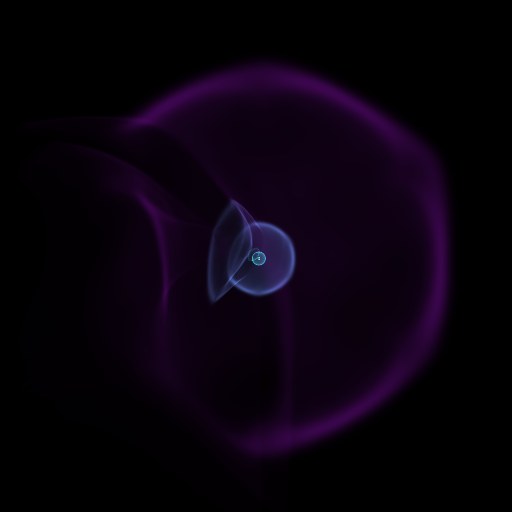

In [142]:
sc = yt.create_scene(ts[10])
# identifying the source
source = sc[0]
source.set_field('density')
source.set_log(True)

# building transfer function
bounds = (1e-18, 1e-12)
tf = yt.ColorTransferFunction(x_bounds=np.log10(bounds))

# tf.add_gaussian(location=-14, width=0.07, height=[1,0,0,1])
# tf.add_gaussian(location=-14.8, width=0.07, height=[0.5,1,1,0.05])
tf.add_layers(5, w=0.005, colormap='viridis')
print(tf)

source.tfh.tf = tf
source.tfh.bounds = bounds
source.tfh.plot('/home/visitor_ap4/code/project/scripts/wr140_tf_density.png', profile_field='density')

sc.save('/home/visitor_ap4/code/project/scripts/wr140_density.png', sigma_clip=6.0)
sc.show()


In [143]:
# cam = sc.camera
# cam.get_focus()
# cam.zoom(6)

# cam.switch_orientation(normal_vector=[1, 0, 0], north_vector=[0, 1, 0])

# sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/frame_0.png', sigma_clip=6.0)

# for i in cam.iter_rotate(np.pi, 60):
#     sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/frame_{i+1}.png', sigma_clip=6.0, render=True)



In [155]:
for i in range(len(ts)):
    sc = yt.create_scene(ts[i])
    # identifying the source
    source = sc[0]
    source.set_field('density')
    source.set_log(True)

    # building transfer function
    bounds = (1e-18, 1e-12)
    tf = yt.ColorTransferFunction(x_bounds=np.log10(bounds))
    tf.add_layers(5, w=0.005, colormap='viridis')
    
    source.tfh.tf = tf
    source.tfh.bounds = bounds
    source.tfh.plot(f'/home/visitor_ap4/code/project/scripts/wr140_tf{i}_density.png', profile_field='density')
    
    cam = sc.camera
    cam.zoom(4)
    # cam.switch_orientation(normal_vector=[1, 0, 0], north_vector=[0, 1, 0])

    sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/ts_stationary/frame_{i}.png', sigma_clip=6.0)
    
    tf.clear()



yt : [INFO     ] 2022-10-27 19:58:43,974 Setting default field to ('gas', 'density')
yt : [WARNING  ] 2022-10-27 19:58:44,830 No previously rendered image found, rendering now.
yt : [INFO     ] 2022-10-27 19:58:44,832 Rendering scene (Can take a while).
yt : [INFO     ] 2022-10-27 19:58:44,835 Creating volume
yt : [INFO     ] 2022-10-27 19:58:46,539 Saving rendered image to /home/visitor_ap4/code/project/scripts/yt_images/ts_stationary/frame_0.png
yt : [INFO     ] 2022-10-27 19:58:46,651 Setting default field to ('gas', 'density')
yt : [WARNING  ] 2022-10-27 19:58:47,152 No previously rendered image found, rendering now.
yt : [INFO     ] 2022-10-27 19:58:47,153 Rendering scene (Can take a while).
yt : [INFO     ] 2022-10-27 19:58:47,155 Creating volume
yt : [INFO     ] 2022-10-27 19:58:48,859 Saving rendered image to /home/visitor_ap4/code/project/scripts/yt_images/ts_stationary/frame_1.png
yt : [INFO     ] 2022-10-27 19:58:48,986 Setting default field to ('gas', 'density')
yt : [WARNI

In [176]:
init_angle = 0

for i in range(len(ts)):
    sc = yt.create_scene(ts[i])

    # identifying the source
    source = sc[0]
    source.set_field('density')
    source.set_log(True)

    # building transfer function
    bounds = (1e-18, 1e-12)
    tf = yt.ColorTransferFunction(x_bounds=np.log10(bounds))
    tf.add_layers(5, w=0.005, colormap='viridis')
    
    source.tfh.tf = tf
    source.tfh.bounds = bounds


    cam = sc.camera
    # cam.zoom(4)
    # cam.switch_orientation(normal_vector=[1, 0, 0], north_vector=[0, 1, 0])
    # cam.rotate(init_angle)

    sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/{i}frame_0.png', sigma_clip=6.0)
    
    
    for j in cam.iter_zoom(1+(i*4/20), 5):
        sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/{i}frame_{j+1}.png', sigma_clip=6.0, render=True)

    # init_angle += np.pi/21

    # for j in cam.iter_rotate(init_angle, 4):
    #   sc.save(f'/home/visitor_ap4/code/project/scripts/yt_images/{i}frame_{j+1}.png', sigma_clip=6.0, render=True)


    
    tf.clear()

yt : [WARNING  ] 2022-10-27 20:37:24,367 No previously rendered image found, rendering now.
yt : [WARNING  ] 2022-10-27 20:37:26,161 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rendered image directly.
yt : [WARNING  ] 2022-10-27 20:37:32,607 No previously rendered image found, rendering now.
yt : [WARNING  ] 2022-10-27 20:37:34,431 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rendered image directly.
yt : [WARNING  ] 2022-10-27 20:37:41,006 No previously rendered image found, rendering now.
yt : [WARNING  ] 2022-10-27 20:37:42,810 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rendered image directly.
yt : [WARNING  ] 2022-10-27 20:37:49,187 No previously rendered image found, rendering now.
yt : [WARNING  ] 2022-10-27 20:37:50,935 Previously rendered image exists, but rendering anyway. Supply 'render=False' to save previously rende